# la Resting ECG de la clase dos es bernoulli! y la estamos tratando como multinomial

# Es mejor que cada una tenga su distribucion

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import norm, bernoulli, multinomial, gaussian_kde, shapiro, kstest, poisson
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn import metrics
import scipy.stats
from sklearn.metrics import classification_report

In [52]:
def probability_categorical(attribute, value, Iwi):
    exitoIwi = len(Iwi[Iwi[attribute] == value])
    nIwi = len(Iwi)
    p = exitoIwi/nIwi
    return p

In [53]:
def fit(predictoras, apredecir, dictionary_of_distributions, esnormal=False):
    # lo estaba haciendo con df, pero podria ser mejor
    df = pd.concat([predictoras, apredecir], axis=1)

    # para que los wi[i] esten boniton
    df = df.sort_values(by=apredecir.name)

    
    classes = apredecir.unique()        # M
    total = len(df)                     # total
    attributes = predictoras.columns    # X_i i \in {1, 2, ...}

    Iwi = []        # Iwi (given wi)
    pwi = []        # a priori probability
    pxjIwi = []     # p(X_j|w_i) 

    newdistributions = {}

    for i in range(len(classes)):                   # For every class

        # Las probabilidades a priori de cada clase en Y. Es decir, P(Y=y_i)

        Iwi.append(df[df[apredecir.name] == classes[i]])    # un dataframe con las X que son de la clase i
        pwi.append(len(Iwi[i])/total)                       # Append the a priori probability
        pxjIwi.append([])                                   # las distribuciones condicionales de cada atributo 

        # creamos un diccionario con las distribuciones de cada atributo para la clase i
        newdistributions[classes[i]] = {}                   # las distribuciones de cada atributo


        # Las funciones de masa o densidad de probabilidad condicionales

        for attribute in attributes:

            if dictionary_of_distributions[attribute] == 'categorica':
                
                if len(Iwi[i][attribute].unique()) == 2:
                    newdistributions[classes[i]][attribute] = 'bernoulli'
                    teta = Iwi[i][attribute].mean()         
                    un_pxiIwi = bernoulli(teta)             
                    pxjIwi[i].append(un_pxiIwi)
                    
                else: 
                    newdistributions[classes[i]][attribute] = 'multinomial'
                    un_pxiIwi = multinomial(1, Iwi[i][attribute].value_counts(normalize=True))
                    pxjIwi[i].append(un_pxiIwi)
                    
                    

            elif dictionary_of_distributions[attribute] == 'entera':
                newdistributions[classes[i]][attribute] = 'poisson'
                lambda_ = Iwi[i][attribute].mean()
                un_pxiIwi = poisson(lambda_)
                pxjIwi[i].append(un_pxiIwi)


            elif dictionary_of_distributions[attribute] == 'continua':

                if esnormal:
                    newdistributions[classes[i]][attribute] = 'normal'
                    xbar = Iwi[i][attribute].mean()
                    s = Iwi[i][attribute].std()
                    un_pxiIwi = norm(xbar, s)
                    pxjIwi[i].append(un_pxiIwi)
                    
                else:
                    newdistributions[classes[i]][attribute] = 'kde'
                    un_pxiIwi = gaussian_kde(Iwi[i][attribute])
                    pxjIwi[i].append(un_pxiIwi)
                    


    return pxjIwi, pwi, Iwi, classes, attributes, newdistributions

In [54]:
def predict(pxjIwi, pwi, Iwi, classes, attributes, newdistributions, age, sex, chest_pain_type, resting_blood_pressure, cholesterol, fasting_blood_sugar, resting_ecg, max_heart_rate, exercise_induced_angina, st_depression, slope, number_of_major_vessels, thal):

    # P(w_i|x) = P(w_i) * P(x|w_i) 
    Pwis = []

    for i, clase in range(len(classes)):

        # It depends on the distribution

        # a priori probability
        Pwi = pwi[clase]
        
        # its easier 
        attributes_values = [age, sex, chest_pain_type, resting_blood_pressure, cholesterol, fasting_blood_sugar, resting_ecg, max_heart_rate, exercise_induced_angina, st_depression, slope, number_of_major_vessels, thal]


        for attribute in range(len(attributes_values)):

            # si tiene dos valores es bernoulli    
            if newdistributions[classes[i]][attribute] == 'poisson':
                evaluation = pxjIwi[clase][attributes[attribute]].pmf(attributes_values[attribute])
                Pwi *= evaluation

            elif newdistributions[classes[i]][attribute] == 'normal':
                evaluation = pxjIwi[clase][attributes[attribute]].pdf(attributes_values[attribute])
                Pwi *= evaluation

            elif newdistributions[classes[i]][attribute] == 'kde':
                evaluation = pxjIwi[clase][attributes[attribute]].pdf(attributes_values[attribute])
                Pwi *= evaluation

            elif newdistributions[classes[i]][attribute] == 'bernoulli':
                evaluation = pxjIwi[clase][attributes[attribute]].pmf(attributes_values[attribute])
                Pwi *= evaluation

            elif newdistributions[classes[i]][attribute] == 'multinomial':
                evaluation = pxjIwi[clase][attributes[attribute]].pmf(attributes_values[attribute])
                Pwi *= evaluation
                
        # list of probabilities|class
        Pwis.append(Pwi)

    # argmax
    argmax = np.argmax(Pwis)

    return argmax

In [55]:
def probar_el_clasificador(predictoras, apredecir, classes, Iwi, distributions, esnormal, pxjIwi, pwi, attributes):

    # Shuffle the rows
    for clase in range(len(classes)):
        Iwi[clase] = Iwi[clase].sample(frac=1).reset_index(drop=True)   

    # Esto era le que estaba pensando de hacer muchos train y test y el promedio de los resultados

    # Es un minitrain porque se divide por los Iwis
    minitrain = []
    minitest = []

    # Se hace asi para tener al menos un wi de cada clase
    for clase in range(len(classes)): 
        minitrain.append(Iwi[clase].iloc[:  int(len(Iwi[clase])*0.8), :])   # 80% of the rows
        minitest.append(Iwi[clase].iloc[int(len(Iwi[clase])*0.8):, :])      # 20% of the rows

    # Un traindf ya es un train bien hecho con todas las clases (del 80%)
    traindf = pd.concat(minitrain, ignore_index=True)
    testdf = pd.concat(minitest, ignore_index=True)

    # Vamos a .fit el traindf
    predictoras_train = traindf[predictoras.columns]    # No es un iloc porque la que queremos predecir puede no ser la ultima
    apredecir_train = traindf[apredecir.name]

    # Vamos a .predict el testdf
    pxjIwi, pwi, Iwi, classes, attributes = fit(predictoras_train, apredecir_train, distributions, esnormal)

    # Columna de predicciones
    predictions = []
    
    for i in range(len(testdf)):
        predictpredict = predict(pxjIwi, pwi, Iwi, classes, attributes, *testdf.iloc[i, :-1])   # *testdf.iloc[i, :-1] is the same as testdf.iloc[i, 0], testdf.iloc[i, 1], ...
        predictions.append(predictpredict)

    # add the predictions to the dataframe
    testdf["PREDICT PREDICT"] = predictions

    return testdf

In [56]:
def matriz_confusion(y_true, y_pred, cmap='Blues', title='Matriz de Confusión', xlabel='Predicciones', ylabel='Verdaderos'):

    cm = confusion_matrix(y_true, y_pred)

    fig, ax = plt.subplots(figsize=(4, 4), dpi=150)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=cmap, ax=ax, colorbar=False)
    # 'Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Grays', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_grey', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gist_yerg', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'grey', 'hot', 'hot_r', 'hsv', 'hsv_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'seismic', 'seismic_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'turbo', 'turbo_r', 'twilight', 'twilight_r', 'twilight_shifted', 'twilight_shifted_r', 'viridis', 'viridis_r', 'winter', 'winter_r'
    
    ax.set_title(title, fontsize=10, fontweight='bold')
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    
    plt.show()

In [57]:
class bayes_naive:

    def __init__(self, normalokde):

        if normalokde == 'normal':
            self.esnormal = True
        else:
            self.esnormal = False

    def fit(self, predictoras, apredecir, dictionary_of_distributions):
        self.pxjIwi, self.pwi, self.Iwi, self.classes, self.attributes = fit(predictoras, apredecir, dictionary_of_distributions, self.esnormal)

        self.predictoras = predictoras
        self.apredecir = apredecir
        self.distributions = dictionary_of_distributions

        return self.pxjIwi, self.pwi, self.Iwi, self.classes, self.attributes

    def predict(self, age, sex, chest_pain_type, resting_blood_pressure, cholesterol, fasting_blood_sugar, resting_ecg, max_heart_rate, exercise_induced_angina, st_depression, slope, number_of_major_vessels, thal):
        return predict(self.pxjIwi, self.pwi, self.Iwi, self.classes, self.attributes, age, sex, chest_pain_type, resting_blood_pressure, cholesterol, fasting_blood_sugar, resting_ecg, max_heart_rate, exercise_induced_angina, st_depression, slope, number_of_major_vessels, thal)
    
    def probar_el_clasificador(self):
        testdf = probar_el_clasificador(self.predictoras, self.apredecir, self.classes, self.Iwi, self.distributions, self.esnormal, self.pxjIwi, self.pwi, self.attributes)
        self.testdf = testdf
        return testdf
    
    def confusion_matrix(self, cmap='Blues', title='Matriz de Confusión', xlabel='Predicciones', ylabel='Verdaderos'):
        self.y_pred = self.testdf['PREDICT PREDICT']
        self.y_true = self.testdf[self.apredecir.name]
        return matriz_confusion(self.y_true, self.y_pred, cmap, title, xlabel, ylabel)
    
    def reporte_de_clasificacion(self):
        return print(classification_report(self.y_true, self.y_pred))



# **Ejemplo**

In [58]:
cleavland = pd.read_csv('05-heart+disease/processed.cleveland.data', header=None, encoding='ISO-8859-1')
hungary = pd.read_csv('05-heart+disease/processed.hungarian.data', header=None, encoding='ISO-8859-1')
switzerland = pd.read_csv('05-heart+disease/processed.switzerland.data', header=None, encoding='ISO-8859-1')
va = pd.read_csv('05-heart+disease/processed.va.data', header=None, encoding='ISO-8859-1')

In [59]:
attributes = ["Age", "Sex", "Chest Pain Type", "Resting Blood Pressure", "Cholesterol", "Fasting Blood Sugar", "Resting ECG", "Max Heart Rate", "Exercise Induced Angina", "ST Depression", "Slope", "Number of Major Vessels", "Thal", "Diagnosis of Heart Disease"]

In [60]:
cleavland.columns = attributes
hungary.columns = attributes
switzerland.columns = attributes
va.columns = attributes

In [61]:
df = pd.concat([cleavland, hungary, switzerland, va], ignore_index=True)

In [62]:
df.replace("?", np.nan, inplace=True)
df.dropna(inplace=True)
df = df.apply(pd.to_numeric)

In [63]:
distributions = {
    'Age': 'continua',
    'Sex': 'categorica',
    'Chest Pain Type': 'entera', 
    'Resting Blood Pressure': 'continua',
    'Cholesterol': 'continua',
    'Fasting Blood Sugar': 'categorica', 
    'Resting ECG': 'categorica',
    'Max Heart Rate': 'continua',
    'Exercise Induced Angina': 'categorica',
    'ST Depression': 'continua',
    'Slope': 'categorica',
    'Number of Major Vessels': 'categorica', 
    'Thal': 'categorica', 
    'Diagnosis of Heart Disease': 'categorica'
}

In [64]:
predictoras = df.iloc[:, :-1]
apredecir = df.iloc[:, -1]

In [65]:
bn = bayes_naive('kde')

In [95]:
def fit(predictoras, apredecir, dictionary_of_distributions, esnormal=False):
    # lo estaba haciendo con df, pero podria ser mejor
    df = pd.concat([predictoras, apredecir], axis=1)

    # para que los wi[i] esten boniton
    df = df.sort_values(by=apredecir.name)

    
    classes = apredecir.unique()        # M
    total = len(df)                     # total
    attributes = predictoras.columns    # X_i i \in {1, 2, ...}

    Iwi = []        # Iwi (given wi)
    pwi = []        # a priori probability
    pxjIwi = []     # p(X_j|w_i) 

    newdistributions = {}

    for i in range(len(classes)):                   # For every class

        # Las probabilidades a priori de cada clase en Y. Es decir, P(Y=y_i)

        Iwi.append(df[df[apredecir.name] == classes[i]])    # un dataframe con las X que son de la clase i
        pwi.append(len(Iwi[i])/total)                       # Append the a priori probability
        pxjIwi.append([])                                   # las distribuciones condicionales de cada atributo 

        # creamos un diccionario con las distribuciones de cada atributo para la clase i
        newdistributions[classes[i]] = {}                   # las distribuciones de cada atributo


        # Las funciones de masa o densidad de probabilidad condicionales

        for attribute in attributes:

            if dictionary_of_distributions[attribute] == 'categorica':
                
                if len(Iwi[i][attribute].unique()) == 2:
                    newdistributions[classes[i]][attribute] = 'bernoulli'
                    teta = Iwi[i][attribute].mean()         
                    un_pxiIwi = bernoulli(teta)             
                    pxjIwi[i].append(un_pxiIwi)
                    
                else: 
                    newdistributions[classes[i]][attribute] = 'multinomial'
                    un_pxiIwi = multinomial(1, Iwi[i][attribute].value_counts(normalize=True))
                    pxjIwi[i].append(un_pxiIwi)
                    
                    

            elif dictionary_of_distributions[attribute] == 'entera':
                newdistributions[classes[i]][attribute] = 'poisson'
                lambda_ = Iwi[i][attribute].mean()
                un_pxiIwi = poisson(lambda_)
                pxjIwi[i].append(un_pxiIwi)


            elif dictionary_of_distributions[attribute] == 'continua':

                if esnormal:
                    newdistributions[classes[i]][attribute] = 'normal'
                    xbar = Iwi[i][attribute].mean()
                    s = Iwi[i][attribute].std()
                    un_pxiIwi = norm(xbar, s)
                    pxjIwi[i].append(un_pxiIwi)
                    
                else:
                    newdistributions[classes[i]][attribute] = 'kde'
                    un_pxiIwi = gaussian_kde(Iwi[i][attribute])
                    pxjIwi[i].append(un_pxiIwi)


    return pxjIwi, pwi, Iwi, classes, attributes, newdistributions

In [96]:
pxjIwi, pwi, Iwi, classes, attributes, newdistributions= fit(predictoras, apredecir, distributions)

In [97]:
newdistributions[0]

{'Age': 'kde',
 'Sex': 'bernoulli',
 'Chest Pain Type': 'poisson',
 'Resting Blood Pressure': 'kde',
 'Cholesterol': 'kde',
 'Fasting Blood Sugar': 'bernoulli',
 'Resting ECG': 'multinomial',
 'Max Heart Rate': 'kde',
 'Exercise Induced Angina': 'bernoulli',
 'ST Depression': 'kde',
 'Slope': 'multinomial',
 'Number of Major Vessels': 'multinomial',
 'Thal': 'multinomial'}

In [69]:
newdistributions[1]

{'Age': 'kde',
 'Sex': 'bernoulli',
 'Chest Pain Type': 'poisson',
 'Resting Blood Pressure': 'kde',
 'Cholesterol': 'kde',
 'Fasting Blood Sugar': 'bernoulli',
 'Resting ECG': 'bernoulli',
 'Max Heart Rate': 'kde',
 'Exercise Induced Angina': 'bernoulli',
 'ST Depression': 'kde',
 'Slope': 'multinomial',
 'Number of Major Vessels': 'multinomial',
 'Thal': 'multinomial'}

In [70]:
fit(predictoras, apredecir, distributions)

([[<scipy.stats._kde.gaussian_kde at 0x227e76664b0>,
 [0.5351170568561873,
  0.11705685618729098,
  0.18729096989966554,
  0.11705685618729098,
  0.043478260869565216],
 [      Age  Sex  Chest Pain Type  Resting Blood Pressure  Cholesterol  \
  0    63.0  1.0              1.0                   145.0        233.0   
  163  58.0  0.0              4.0                   100.0        248.0   
  164  48.0  1.0              3.0                   124.0        255.0   
  165  57.0  1.0              4.0                   132.0        207.0   
  167  54.0  0.0              2.0                   132.0        288.0   
  ..    ...  ...              ...                     ...          ...   
  94   63.0  0.0              3.0                   135.0        252.0   
  99   48.0  1.0              4.0                   122.0        222.0   
  84   52.0  1.0              2.0                   120.0        325.0   
  92   62.0  1.0              3.0                   130.0        231.0   
  93   44.0  0.0 

In [71]:
pxjIwi

[[<scipy.stats._kde.gaussian_kde at 0x227e5305f10>,

In [72]:
for i in range(len(pxjIwi[0])):
    print(i, pxjIwi[0][i])

0 <scipy.stats._kde.gaussian_kde object at 0x00000227E5305F10>
1 <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000227E5305E20>
2 <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000227E53051C0>
3 <scipy.stats._kde.gaussian_kde object at 0x00000227E53052B0>
4 <scipy.stats._kde.gaussian_kde object at 0x00000227E5304C20>
5 <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000227E5305460>
6 <scipy.stats._multivariate.multinomial_frozen object at 0x00000227E5304F80>
7 <scipy.stats._kde.gaussian_kde object at 0x00000227E5306690>
8 <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000227E5383E90>
9 <scipy.stats._kde.gaussian_kde object at 0x00000227E5304260>
10 <scipy.stats._multivariate.multinomial_frozen object at 0x00000227E5304710>
11 <scipy.stats._multivariate.multinomial_frozen object at 0x00000227E539BD10>
12 <scipy.stats._multivariate.multinomial_frozen object at 0x00000227E75247A0>


In [73]:
for i in range(len(pxjIwi[1])):
    print(i, pxjIwi[1][i])

0 <scipy.stats._kde.gaussian_kde object at 0x00000227E7548A10>
1 <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000227E754B800>
2 <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000227E7549220>
3 <scipy.stats._kde.gaussian_kde object at 0x00000227E754B9E0>
4 <scipy.stats._kde.gaussian_kde object at 0x00000227E7549C70>
5 <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000227E754AAE0>
6 <scipy.stats._multivariate.multinomial_frozen object at 0x00000227E754B500>
7 <scipy.stats._kde.gaussian_kde object at 0x00000227E529C230>
8 <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000227E52B3620>
9 <scipy.stats._kde.gaussian_kde object at 0x00000227A42D6600>
10 <scipy.stats._multivariate.multinomial_frozen object at 0x00000227A42D6840>
11 <scipy.stats._multivariate.multinomial_frozen object at 0x00000227E52FFF80>
12 <scipy.stats._multivariate.multinomial_frozen object at 0x00000227E52FFE90>


In [74]:
for i in range(len(pxjIwi[2])):
    print(i, pxjIwi[2][i])

0 <scipy.stats._kde.gaussian_kde object at 0x00000227E52FD430>
1 <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000227E52FD2E0>
2 <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000227E52FD1F0>
3 <scipy.stats._kde.gaussian_kde object at 0x00000227E52FC440>
4 <scipy.stats._kde.gaussian_kde object at 0x00000227E52FCE90>
5 <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000227E52FCF50>
6 <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000227E52FCD40>
7 <scipy.stats._kde.gaussian_kde object at 0x00000227E52FC230>
8 <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000227E52FC2C0>
9 <scipy.stats._kde.gaussian_kde object at 0x00000227E52FC5F0>
10 <scipy.stats._multivariate.multinomial_frozen object at 0x00000227E52FC1A0>
11 <scipy.stats._multivariate.multinomial_frozen object at 0x00000227E5263500>
12 <scipy.stats._multivariate.multinomial_frozen object at 0x00000227E7541700>


In [75]:
for i in range(len(pxjIwi[3])):
    print(i, pxjIwi[3][i])

0 <scipy.stats._kde.gaussian_kde object at 0x00000227E7543950>
1 <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000227E7541040>
2 <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000227E75405F0>
3 <scipy.stats._kde.gaussian_kde object at 0x00000227E75439E0>
4 <scipy.stats._kde.gaussian_kde object at 0x00000227E75419D0>
5 <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000227E7540920>
6 <scipy.stats._multivariate.multinomial_frozen object at 0x00000227E7541DC0>
7 <scipy.stats._kde.gaussian_kde object at 0x00000227E75438C0>
8 <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000227E5306390>
9 <scipy.stats._kde.gaussian_kde object at 0x00000227E75C7AD0>
10 <scipy.stats._multivariate.multinomial_frozen object at 0x00000227E75C6630>
11 <scipy.stats._multivariate.multinomial_frozen object at 0x00000227E75CA0C0>
12 <scipy.stats._multivariate.multinomial_frozen object at 0x00000227E75C6C60>


In [76]:
for i in range(len(pxjIwi[4])):
    print(i, pxjIwi[4][i])

0 <scipy.stats._kde.gaussian_kde object at 0x00000227E7658740>
1 <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000227E765AB70>
2 <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000227E765AF30>
3 <scipy.stats._kde.gaussian_kde object at 0x00000227E765B770>
4 <scipy.stats._kde.gaussian_kde object at 0x00000227E765B0E0>
5 <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000227E765B980>
6 <scipy.stats._multivariate.multinomial_frozen object at 0x00000227E765B3B0>
7 <scipy.stats._kde.gaussian_kde object at 0x00000227E765B6B0>
8 <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000227E765BD70>
9 <scipy.stats._kde.gaussian_kde object at 0x00000227E765BF20>
10 <scipy.stats._multivariate.multinomial_frozen object at 0x00000227E7664470>
11 <scipy.stats._multivariate.multinomial_frozen object at 0x00000227E7664380>
12 <scipy.stats._multivariate.multinomial_frozen object at 0x00000227E7664710>


In [98]:
pxjIwi[4][0].evaluate(50)

array([0.01892004])

In [78]:
pwi

[0.5351170568561873,
 0.11705685618729098,
 0.18729096989966554,
 0.11705685618729098,
 0.043478260869565216]

In [99]:
Iwi[3]

,Age,Sex,Chest Pain Type,Resting Blood Pressure,Cholesterol,Fasting Blood Sugar,Resting ECG,Max Heart Rate,Exercise Induced Angina,ST Depression,Slope,Number of Major Vessels,Thal,Diagnosis of Heart Disease
213,66.0,0.0,4.0,178.0,228.0,1.0,0.0,165.0,1.0,1.0,2.0,2.0,7.0,3
228,54.0,1.0,4.0,110.0,206.0,0.0,2.0,108.0,1.0,0.0,2.0,1.0,3.0,3
6,62.0,0.0,4.0,140.0,268.0,0.0,2.0,160.0,0.0,3.6,3.0,2.0,3.0,3
282,55.0,0.0,4.0,128.0,205.0,0.0,1.0,130.0,1.0,2.0,2.0,1.0,7.0,3
36,43.0,1.0,4.0,120.0,177.0,0.0,2.0,120.0,1.0,2.5,2.0,0.0,7.0,3
180,48.0,1.0,4.0,124.0,274.0,0.0,2.0,166.0,0.0,0.5,2.0,0.0,7.0,3
104,49.0,1.0,3.0,120.0,188.0,0.0,0.0,139.0,0.0,2.0,2.0,3.0,7.0,3
154,64.0,1.0,4.0,120.0,246.0,0.0,2.0,96.0,1.0,2.2,3.0,1.0,3.0,3
38,55.0,1.0,4.0,132.0,353.0,0.0,0.0,132.0,1.0,1.2,2.0,1.0,7.0,3
126,56.0,0.0,4.0,200.0,288.0,1.0,2.0,133.0,1.0,4.0,3.0,2.0,7.0,3


In [80]:
classes

array([0, 2, 1, 3, 4], dtype=int64)

In [81]:
attributes

Index(['Age', 'Sex', 'Chest Pain Type', 'Resting Blood Pressure',
       'Cholesterol', 'Fasting Blood Sugar', 'Resting ECG', 'Max Heart Rate',
       'Exercise Induced Angina', 'ST Depression', 'Slope',
       'Number of Major Vessels', 'Thal'],
      dtype='object')

In [100]:
age = 63
sex = 1
chest_pain_type = 3
resting_blood_pressure = 145
cholesterol = 233
fasting_blood_sugar = 1
resting_ecg = 0
max_heart_rate = 150
exercise_induced_angina = 0
st_depression = 2.3
slope = 0
number_of_major_vessels = 0
thal = 1

In [83]:
newdistributions[1]

{'Age': 'kde',
 'Sex': 'bernoulli',
 'Chest Pain Type': 'poisson',
 'Resting Blood Pressure': 'kde',
 'Cholesterol': 'kde',
 'Fasting Blood Sugar': 'bernoulli',
 'Resting ECG': 'bernoulli',
 'Max Heart Rate': 'kde',
 'Exercise Induced Angina': 'bernoulli',
 'ST Depression': 'kde',
 'Slope': 'multinomial',
 'Number of Major Vessels': 'multinomial',
 'Thal': 'multinomial'}

In [84]:
attributes

Index(['Age', 'Sex', 'Chest Pain Type', 'Resting Blood Pressure',
       'Cholesterol', 'Fasting Blood Sugar', 'Resting ECG', 'Max Heart Rate',
       'Exercise Induced Angina', 'ST Depression', 'Slope',
       'Number of Major Vessels', 'Thal'],
      dtype='object')

In [101]:
for i in range(len(classes)):
    for attribute in attributes:
        print(f'{attribute}   {newdistributions[i][attribute]}')
    print()

Age   kde
Sex   bernoulli
Chest Pain Type   poisson
Resting Blood Pressure   kde
Cholesterol   kde
Fasting Blood Sugar   bernoulli
Resting ECG   multinomial
Max Heart Rate   kde
Exercise Induced Angina   bernoulli
ST Depression   kde
Slope   multinomial
Number of Major Vessels   multinomial
Thal   multinomial

Age   kde
Sex   bernoulli
Chest Pain Type   poisson
Resting Blood Pressure   kde
Cholesterol   kde
Fasting Blood Sugar   bernoulli
Resting ECG   bernoulli
Max Heart Rate   kde
Exercise Induced Angina   bernoulli
ST Depression   kde
Slope   multinomial
Number of Major Vessels   multinomial
Thal   multinomial

Age   kde
Sex   bernoulli
Chest Pain Type   poisson
Resting Blood Pressure   kde
Cholesterol   kde
Fasting Blood Sugar   bernoulli
Resting ECG   multinomial
Max Heart Rate   kde
Exercise Induced Angina   bernoulli
ST Depression   kde
Slope   multinomial
Number of Major Vessels   multinomial
Thal   multinomial

Age   kde
Sex   bernoulli
Chest Pain Type   poisson
Resting Blood 

In [102]:
newdistributions[1]['Age'] == 'kde'

True

In [103]:
for i in range(len(classes)):
    for attribute in range(len(attributes)):
        print(f'{attributes[attribute]}   {newdistributions[i][attributes[attribute]]}')
    print()

Age   kde
Sex   bernoulli
Chest Pain Type   poisson
Resting Blood Pressure   kde
Cholesterol   kde
Fasting Blood Sugar   bernoulli
Resting ECG   multinomial
Max Heart Rate   kde
Exercise Induced Angina   bernoulli
ST Depression   kde
Slope   multinomial
Number of Major Vessels   multinomial
Thal   multinomial

Age   kde
Sex   bernoulli
Chest Pain Type   poisson
Resting Blood Pressure   kde
Cholesterol   kde
Fasting Blood Sugar   bernoulli
Resting ECG   bernoulli
Max Heart Rate   kde
Exercise Induced Angina   bernoulli
ST Depression   kde
Slope   multinomial
Number of Major Vessels   multinomial
Thal   multinomial

Age   kde
Sex   bernoulli
Chest Pain Type   poisson
Resting Blood Pressure   kde
Cholesterol   kde
Fasting Blood Sugar   bernoulli
Resting ECG   multinomial
Max Heart Rate   kde
Exercise Induced Angina   bernoulli
ST Depression   kde
Slope   multinomial
Number of Major Vessels   multinomial
Thal   multinomial

Age   kde
Sex   bernoulli
Chest Pain Type   poisson
Resting Blood 

In [104]:
len(pxjIwi[0][6].p)

3

In [105]:
for i in range(len(classes)):
    for attribute in range(len(attributes)):
        print(f'{attributes[attribute]}    {pxjIwi[i][attribute]}')
    print()

Age    <scipy.stats._kde.gaussian_kde object at 0x00000227E7676C90>
Sex    <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000227E7676C30>
Chest Pain Type    <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000227E7676F90>
Resting Blood Pressure    <scipy.stats._kde.gaussian_kde object at 0x00000227E7676EA0>
Cholesterol    <scipy.stats._kde.gaussian_kde object at 0x00000227E7676B70>
Fasting Blood Sugar    <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000227E7676570>
Resting ECG    <scipy.stats._multivariate.multinomial_frozen object at 0x00000227E5306600>
Max Heart Rate    <scipy.stats._kde.gaussian_kde object at 0x00000227E53055B0>
Exercise Induced Angina    <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000227E767A1B0>
ST Depression    <scipy.stats._kde.gaussian_kde object at 0x00000227E76783E0>
Slope    <scipy.stats._multivariate.multinomial_frozen object at 0x00000227E7678950>
Number of Major Vessels 

In [140]:
def numtoarray(num, size):
    array = [0] * size
    array[num] = 1
    return array

def predict(pxjIwi, pwi, Iwi, classes, attributes, newdistributions, age, sex, chest_pain_type, resting_blood_pressure, cholesterol, fasting_blood_sugar, resting_ecg, max_heart_rate, exercise_induced_angina, st_depression, slope, number_of_major_vessels, thal):

    # P(w_i|x) = P(w_i) * P(x|w_i)
    Pwis = []
            # its easier 
    attributes_values = [age, sex, chest_pain_type, resting_blood_pressure, cholesterol, fasting_blood_sugar, resting_ecg, max_heart_rate, exercise_induced_angina, st_depression, slope, number_of_major_vessels, thal]


    for i in range(len(classes)):

        # It depends on the distribution

        # a priori probability
        Pwi = pwi[i]
        for attribute in range(len(attributes_values)):
            
            # el diccionario puede entrar a i porque es un num, attributes[attribute] es el nombre del atributo (attributes[0] = 'Age')
            # newdistributions[1]['Age'] == 'kde' o 'normal' 
            if newdistributions[i][attributes[attribute]] == scipy.stats._discrete_distns.bernoulli_gen:
                # pxjIwi[i][attribute] es donde esta una distribucion
                evaluation = pxjIwi[i][attribute].pmf(attributes_values[attribute])
                Pwi *= evaluation

            elif newdistributions[i][attributes[attribute]] == scipy.stats._continuous_distns.norm_gen:
                evaluation = pxjIwi[i][attribute].pdf(attributes_values[attribute])
                Pwi *= evaluation

            elif newdistributions[i][attributes[attribute]] == scipy.stats._kde.gaussian_kde:
                evaluation = pxjIwi[i][attribute].pdf(attributes_values[attribute])
                Pwi *= evaluation

            # no se bien que paso aqui, habia una con etiqueta multinomial pero era bernoulli
            elif type(pxjIwi[i][attribute]) == scipy.stats._distn_infrastructure.rv_discrete_frozen:
                evaluation = pxjIwi[i][attribute].pmf(attributes_values[attribute])
                Pwi *= evaluation

            elif type(pxjIwi[i][attribute]) == scipy.stats._multivariate.multinomial_frozen:
                arrvalue = numtoarray(attributes_values[attribute], len(pxjIwi[i][attribute].p))
                evaluation = pxjIwi[i][attribute].pmf(arrvalue)
                Pwi *= evaluation

            
        # list of probabilities|class
        Pwis.append(Pwi)

    # argmax
    argmax = np.argmax(Pwis)

    return argmax

In [139]:
type(pxjIwi[0][0])

scipy.stats._kde.gaussian_kde

In [126]:
attributes_values = [age, sex, chest_pain_type, resting_blood_pressure, cholesterol, fasting_blood_sugar, resting_ecg, max_heart_rate, exercise_induced_angina, st_depression, slope, number_of_major_vessels, thal]


In [133]:
import scipy.stats

for i in range(len(classes)):

    # It depends on the distribution

    # a priori probability
    Pwi = pwi[i]

    for attribute in range(len(attributes_values)):

        if newdistributions[i][attributes[attribute]] == 'multinomial':
            if type(pxjIwi[i][attribute]) == scipy.stats._multivariate.multinomial_frozen:
                num = attributes_values[attribute]
                size = len(pxjIwi[i][attribute].p)
                arrvalue = numtoarray(num, size)
                print(arrvalue)
                evaluation = pxjIwi[i][attribute].pmf(arrvalue)
                Pwi *= evaluation
                print(f'el atributo {attributes[attribute]} es multinomial, la clase {i} tiene una probabilidad de {evaluation}')
            # no se bien que paso aqui, habia una con etiqueta multinomial pero era bernoulli
            elif type(pxjIwi[i][attribute]) == scipy.stats._distn_infrastructure.rv_discrete_frozen:
                evaluation = pxjIwi[i][attribute].pmf(attributes_values[attribute])
                Pwi *= evaluation

[1, 0, 0]
el atributo Resting ECG es multinomial, la clase 0 tiene una probabilidad de 0.575
[1, 0, 0]
el atributo Slope es multinomial, la clase 0 tiene una probabilidad de 0.64375
[1, 0, 0, 0]
el atributo Number of Major Vessels es multinomial, la clase 0 tiene una probabilidad de 0.80625
[0, 1, 0]
el atributo Thal es multinomial, la clase 0 tiene una probabilidad de 0.16875
[1, 0, 0]
el atributo Slope es multinomial, la clase 1 tiene una probabilidad de 0.7142857142857143
[1, 0, 0, 0]
el atributo Number of Major Vessels es multinomial, la clase 1 tiene una probabilidad de 0.4
[0, 1, 0]
el atributo Thal es multinomial, la clase 1 tiene una probabilidad de 0.2
[1, 0, 0]
el atributo Slope es multinomial, la clase 2 tiene una probabilidad de 0.5714285714285714
[1, 0, 0, 0]
el atributo Number of Major Vessels es multinomial, la clase 2 tiene una probabilidad de 0.5
[0, 1, 0]
el atributo Thal es multinomial, la clase 2 tiene una probabilidad de 0.39285714285714285
[1, 0, 0]
el atributo Re

In [ ]:
for i in range(len(classes)):
    for attribute in range(len(attributes)):
        print(f'{attributes[attribute]}    {pxjIwi[i][attribute]}')
    print()

    

In [141]:
predict(pxjIwi, pwi, Iwi, classes, attributes, newdistributions, age, sex, chest_pain_type, resting_blood_pressure, cholesterol, fasting_blood_sugar, resting_ecg, max_heart_rate, exercise_induced_angina, st_depression, slope, number_of_major_vessels, thal)

2

In [ ]:
bn.predict(age, sex, chest_pain_type, resting_blood_pressure, cholesterol, fasting_blood_sugar, resting_ecg, max_heart_rate, exercise_induced_angina, st_depression, slope, number_of_major_vessels, thal)

1

In [ ]:
testdff = bn.probar_el_clasificador()
testdff

,Age,Sex,Chest Pain Type,Resting Blood Pressure,Cholesterol,Fasting Blood Sugar,Resting ECG,Max Heart Rate,Exercise Induced Angina,ST Depression,Slope,Number of Major Vessels,Thal,Diagnosis of Heart Disease,PREDICT PREDICT
0,42.0,1.0,2.0,120.0,295.0,0.0,0.0,162.0,0.0,0.0,1.0,0.0,3.0,0,0
1,74.0,0.0,2.0,120.0,269.0,0.0,2.0,121.0,1.0,0.2,1.0,1.0,3.0,0,0
2,50.0,0.0,4.0,110.0,254.0,0.0,2.0,159.0,0.0,0.0,1.0,0.0,3.0,0,0
3,57.0,1.0,4.0,110.0,201.0,0.0,0.0,126.0,1.0,1.5,2.0,0.0,6.0,0,2
4,58.0,0.0,4.0,130.0,197.0,0.0,0.0,131.0,0.0,0.6,2.0,0.0,3.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56,54.0,1.0,4.0,122.0,286.0,0.0,2.0,116.0,1.0,3.2,2.0,2.0,3.0,3,3
57,58.0,1.0,4.0,128.0,259.0,0.0,2.0,130.0,1.0,3.0,2.0,2.0,7.0,3,1
58,57.0,1.0,4.0,165.0,289.0,1.0,2.0,124.0,0.0,1.0,2.0,3.0,7.0,4,1
59,58.0,1.0,3.0,112.0,230.0,0.0,2.0,165.0,0.0,2.5,2.0,1.0,7.0,4,2


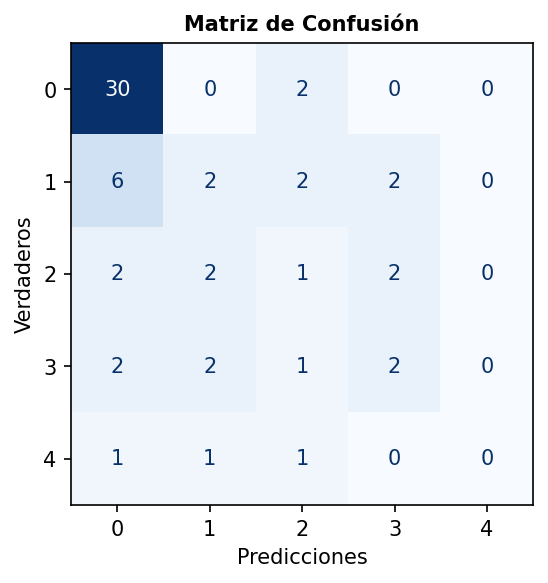

In [ ]:
bn.confusion_matrix()

In [ ]:
bn.reporte_de_clasificacion()

              precision    recall  f1-score   support

           0       0.73      0.94      0.82        32
           1       0.29      0.17      0.21        12
           2       0.14      0.14      0.14         7
           3       0.33      0.29      0.31         7
           4       0.00      0.00      0.00         3

    accuracy                           0.57        61
   macro avg       0.30      0.31      0.30        61
weighted avg       0.49      0.57      0.52        61



c:\Users\herie\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\herie\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\herie\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo